# Import Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pickle

In [11]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):

    imagePaths = []

    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)

    return imagePaths

Import data

In [12]:
imagePaths = list_images("data")

labels = []
logos = []
#Boucle qui stocke tous les visages dans data_faces et les noms dans labels
for im in imagePaths :

    image = cv2.imread(im)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if len(imagePaths)>0 :
        logos.append(image)
        if 'BT' in im :
            labels.append([1,0,0,0,0,0])
        elif 'exit' in im :
            labels.append([0,1,0,0,0,0])
        elif 'extincteur' in im :
            labels.append([0,0,1,0,0,0])
        elif 'incendie' in im :
            labels.append([0,0,0,1,0,0])
        elif 'porte' in im :
            labels.append([0,0,0,0,1,0])
        else :
            labels.append([0,0,0,0,0,1])


data_dictionaire = (logos,labels)
pickle.dump(data_dictionaire, open("data.p","wb"))

In [13]:
from sklearn.model_selection import train_test_split

#Récupere les données de "data.p"
logos , labels = pickle.load(open("data.p",'rb'))

#Normalise les visages et les labels
logos = (np.array(logos) / 255)
#logos =np.array([np.array(i,dtype=float) for i in logos])
labels = np.array(labels).astype('float32')

#Sépare les données en test et validation
train_images, test_images, train_labels, test_labels  = train_test_split(logos,labels,train_size=0.7, test_size=0.30)

print("train image size : " , train_images.shape)
print("test image size : " , test_images.shape)

train image size :  (86, 128, 128, 3)
test image size :  (38, 128, 128, 3)


Model

In [16]:
from tensorflow.keras import datasets, layers, models
# Voici le réseau que nous avons décidé d'utiliser dans cet exercice
model = models.Sequential()
model.add( layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,3)) )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Conv2D(64, (3, 3), activation='relu') )
model.add( layers.MaxPooling2D((2, 2)) )
model.add( layers.Flatten())
model.add( layers.Dense(60, activation='relu'))
model.add(layers.Dropout(0.5)) # On rajoute un dropout pour éviter l'overfitting
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entrainement du réseau
history = model.fit(train_images,
                    train_labels,
                    batch_size=5,
                    epochs=50,
                    validation_data=(test_images,test_labels))

model.save("model")

Train on 86 samples, validate on 38 samples
Epoch 1/50
86/86 [==============================] - 5s 60ms/sample - loss: 0.3596 - acc: 0.8450 - val_loss: 0.3389 - val_acc: 0.8772
Epoch 2/50
86/86 [==============================] - 4s 52ms/sample - loss: 0.2783 - acc: 0.8760 - val_loss: 0.2399 - val_acc: 0.8947
Epoch 3/50
86/86 [==============================] - 4s 50ms/sample - loss: 0.2341 - acc: 0.8992 - val_loss: 0.2068 - val_acc: 0.8991
Epoch 4/50
86/86 [==============================] - 4s 50ms/sample - loss: 0.1998 - acc: 0.9031 - val_loss: 0.1628 - val_acc: 0.9167
Epoch 5/50
86/86 [==============================] - 4s 49ms/sample - loss: 0.1474 - acc: 0.9264 - val_loss: 0.1466 - val_acc: 0.9518
Epoch 6/50
86/86 [==============================] - 4s 50ms/sample - loss: 0.1188 - acc: 0.9360 - val_loss: 0.1254 - val_acc: 0.9649
Epoch 7/50
86/86 [==============================] - 4s 51ms/sample - loss: 0.1419 - acc: 0.9516 - val_loss: 0.1006 - val_acc: 0.9605
Epoch 8/50
86/86 [=======

TypeError: save() missing 1 required positional argument: 'filepath'

float64


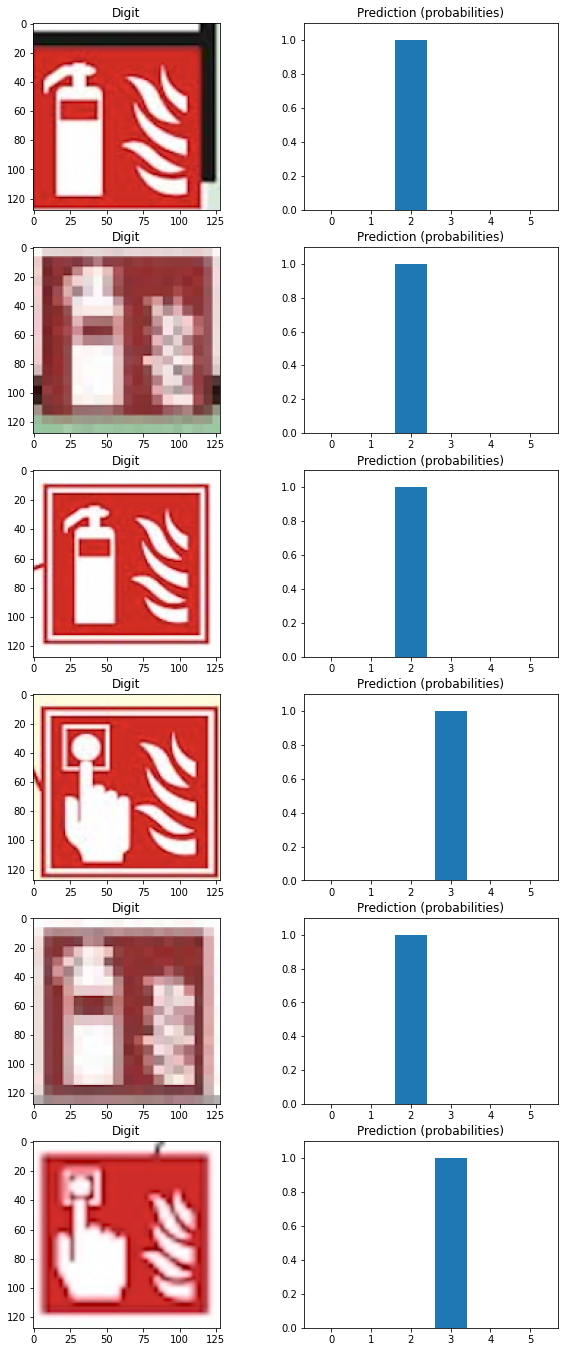

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [19]:
predictions = model.predict(test_images)
dict_logos = {"BT": 0, "exit": 1, "extincteur": 2, "incendie": 3, "porte": 4}

batch_size = 6
inputs  = test_images[0 : 6,:]
print(inputs.dtype)
outputs = predictions[0 : 6,:]

f, ax = plt.subplots(batch_size,2, figsize=(10,4*batch_size))
for i in range(batch_size):
    ax[i,0].imshow(inputs[i,:,:])
    ax[i,0].set_title("Digit")
    ax[i,1].bar(range(6), outputs[i,:])
    ax[i,1].set_title("Prediction (probabilities)")
    ax[i,1].set_xticks(range(6))
    ax[i,1].set_ylim((0,1.1))

plt.show()

print(test_labels[0:6])

## Training and lossing test

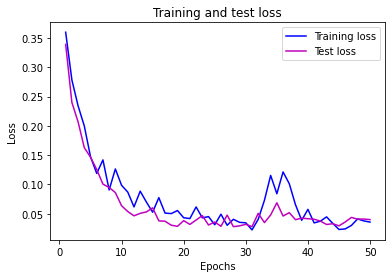

In [20]:
train_acc = history.history['acc']
test_acc = history.history['val_acc']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, linestyle='-', color='b', label='Training loss')
plt.plot(epochs, test_loss, linestyle='-', color='m', label='Test loss')

plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Find logos in the plan

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread("plan.jpg")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret,thresh1 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)

#img = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
#img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

cv2.imwrite('roi2.jpg', thresh1)
contours, hierarchy = cv2.findContours(thresh1, cv2.CONTOURS_MATCH_I3, cv2.CHAIN_APPROX_SIMPLE)

coord=[]
for con in contours :
    [x, y, w, h] = cv2.boundingRect(con)
    if  w > min(image.shape[0:2])*0.02  and  w > min(image.shape[0:2])*0.02 and w < min(image.shape[0:2])*0.1 and h < min(image.shape[0:2])*0.1:
        #cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        coord.append((x,y,x+w,y+h))

#cv2.imwrite('roi.jpg', image)

## Predict on each logos

In [23]:
coord[2]

(1832, 1205, 1865, 1241)

In [30]:
true_logos =[]
for c in coord :
    img_c = cv2.resize(image[c[1]: c[3],c[0]: c[2]]/255, (128,128), interpolation = cv2.INTER_AREA)
    pred = model.predict(np.expand_dims(img_c, axis=0))
    if np.max(pred) ==1:
        true_logos.append((c,np.argmax(pred)))

print(true_logos)

[((47, 1247, 104, 1308), 1), ((61, 1284, 89, 1304), 1), ((1832, 1205, 1865, 1241), 1), ((1550, 1075, 1594, 1077), 1), ((1551, 981, 1595, 984), 1), ((1192, 956, 1293, 1006), 1), ((1361, 954, 1461, 1004), 1), ((898, 1031, 952, 1038), 1), ((898, 1020, 952, 1030), 1), ((898, 1007, 952, 1019), 1), ((898, 995, 952, 1006), 1), ((897, 922, 954, 994), 1), ((898, 909, 952, 921), 1), ((1608, 885, 1648, 914), 1), ((1564, 879, 1593, 920), 1), ((89, 1165, 117, 1186), 1), ((71, 1083, 105, 1117), 1), ((74, 1097, 102, 1113), 1), ((69, 990, 106, 1023), 1), ((73, 994, 102, 1020), 1), ((70, 943, 105, 978), 1), ((71, 901, 104, 935), 1), ((943, 832, 983, 862), 1), ((998, 827, 1027, 867), 1), ((902, 819, 937, 853), 1), ((900, 775, 935, 805), 1), ((1599, 739, 1695, 790), 1), ((1602, 775, 1691, 786), 1), ((1027, 731, 1061, 766), 1), ((536, 1009, 580, 1065), 1), ((517, 1006, 578, 1065), 1), ((517, 1003, 577, 1051), 1), ((517, 995, 582, 1023), 1), ((517, 987, 582, 1004), 1), ((517, 970, 582, 985), 1), ((517, 954

In [41]:
def writeimg(a,z,e,r):
    cv2.imwrite('roi2.jpg', image[z:r,a:e])

writeimg(69, 990, 106, 1023)

In [140]:
img_c = cv2.resize(image[879:920,1564:1593]/255, (128,128), interpolation = cv2.INTER_AREA)
pred = model.predict(np.expand_dims(img_c, axis=0))
print(pred)
np.max(pred)

[[1.6675878e-17 1.0000000e+00 2.1598529e-16 4.0754138e-26 0.0000000e+00
  1.2437066e-20]]


1.0

In [135]:
y=0
for i in true_logos:
    r = i[0]
    print(r)
    cv2.imwrite('data/image' + str(y) + '.png', image[r[1]: r[3],r[0]: r[2]])
    y=y+1

(47, 1247, 104, 1308)
(61, 1284, 89, 1304)
(1832, 1205, 1865, 1241)
(1207, 1069, 1238, 1105)
(1435, 1063, 1467, 1100)
(1057, 994, 1089, 1030)
(1548, 979, 1597, 1079)
(1192, 956, 1293, 1006)
(1361, 954, 1461, 1004)
(898, 1031, 952, 1038)
(898, 1020, 952, 1030)
(898, 1007, 952, 1019)
(898, 995, 952, 1006)
(897, 922, 954, 994)
(898, 909, 952, 921)
(1560, 877, 1651, 922)
(1608, 885, 1648, 914)
(1564, 879, 1593, 920)
(1108, 875, 1144, 906)
(1417, 872, 1449, 909)
(56, 1159, 119, 1191)
(89, 1165, 117, 1186)
(71, 1083, 105, 1117)
(74, 1097, 102, 1113)
(71, 1042, 104, 1075)
(69, 990, 106, 1023)
(73, 994, 102, 1020)
(70, 943, 105, 978)
(71, 901, 104, 935)
(940, 825, 1031, 870)
(943, 832, 983, 862)
(998, 827, 1027, 867)
(902, 819, 937, 853)
(900, 775, 935, 805)
(1599, 739, 1695, 790)
(1602, 775, 1691, 786)
(1027, 731, 1061, 766)
(536, 1009, 580, 1065)
(517, 1006, 578, 1065)
(517, 1003, 577, 1051)
(517, 995, 582, 1023)
(517, 987, 582, 1004)
(517, 970, 582, 985)
(517, 954, 582, 969)
(517, 942, 582,

In [138]:
true_logos[17]

((1564, 879, 1593, 920), 1)